In [111]:
import numpy as np
from qiskit import BasicAer, IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.aqua.components.oracles import CustomCircuitOracle, LogicalExpressionOracle
from qiskit.visualization import plot_histogram
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle, TruthTableOracle
from matplotlib import pyplot as plt


In [126]:
def process_oracle(qc,variable_qubits,clause_qubits,output_qubits, v):
    qc.x(clause_qubits) #all of them are inversed
    
    state = [False]*len(v[0])
    for j in reversed(range(len(v))): #clause in v:
        for i in range(len(v[j])):
            if(v[j][i] != state[i]):
                qc.x(variable_qubits[i])
                state[i] = not state[i]
        qc.mcx(variable_qubits, clause_qubits[j])

# def expression_to_oracle(qc,variable_qubits,clause_qubits,output_qubits, ancilla, v): #must be 3SAT with 3 var
def expression_to_oracle(qc,variable_qubits,clause_qubits,output_qubits, v): #must be 3SAT with 3 var
    process_oracle(qc,variable_qubits,clause_qubits,output_qubits, v)
    # qc.mcx(clause_qubits,output_qubits,ancilla)
    qc.mcx(clause_qubits,output_qubits)
    process_oracle(qc,variable_qubits,clause_qubits,output_qubits, v) #reverse

In [127]:
# variable_qubits = QuantumRegister(3, name='v')
# clause_qubits = QuantumRegister(3, name='c')
# output_qubits = QuantumRegister(1, name='o')
# # variable_qubits = QuantumRegister(2, name='v')
# # clause_qubits = QuantumRegister(2, name='c')
# # output_qubits = QuantumRegister(1, name='o')
# qc = QuantumCircuit(variable_qubits, clause_qubits, output_qubits)

# -1 -2 -3 0
# 1 -2 3 0
# 1 2 -3 0
v = [[True,  True,  False],
    [False, False, False], 
     [True,  False, True ]]

vari = len(v[0])
clau = len(v)

variable_qubits = QuantumRegister(vari, name='v')
clause_qubits = QuantumRegister(clau, name='c')
# ancilla = QuantumRegister(1, name='a')
output_qubits = QuantumRegister(1, name='o')
# qc = QuantumCircuit(variable_qubits, clause_qubits, ancilla, output_qubits)
qc = QuantumCircuit(variable_qubits, clause_qubits, output_qubits)
# expression_to_oracle(qc, variable_qubits, clause_qubits, output_qubits, ancilla, v)
expression_to_oracle(qc, variable_qubits, clause_qubits, output_qubits, v)

In [128]:
expression = '''
c example DIMACS-CNF 3-SAT
p cnf 3 3
1 2 -3 0
-1 -2 -3 0
1 -2 3 0
'''

In [129]:
expressionClass = LogicalExpressionOracle(expression)
oracle = CustomCircuitOracle([variable_qubits, clause_qubits], output_qubits, qc, evaluate_classically_callback=expressionClass.evaluate_classically)
print(oracle.construct_circuit())

     ┌───┐               ┌───┐     ┌───┐                    ┌───┐     
v_0: ┤ X ├──■─────────■──┤ X ├──■──┤ X ├───────■─────────■──┤ X ├──■──
     ├───┤  │  ┌───┐  │  └───┘  │  ├───┤       │  ┌───┐  │  └───┘  │  
v_1: ┤ X ├──■──┤ X ├──■─────────■──┤ X ├───────■──┤ X ├──■─────────■──
     └───┘  │  ├───┤  │  ┌───┐  │  └───┘       │  ├───┤  │  ┌───┐  │  
v_2: ───────■──┤ X ├──■──┤ X ├──■──────────────■──┤ X ├──■──┤ X ├──■──
     ┌───┐  │  └───┘  │  └───┘┌─┴─┐     ┌───┐  │  └───┘  │  └───┘┌─┴─┐
c_0: ┤ X ├──┼─────────┼───────┤ X ├──■──┤ X ├──┼─────────┼───────┤ X ├
     ├───┤  │       ┌─┴─┐     └───┘  │  ├───┤  │       ┌─┴─┐     └───┘
c_1: ┤ X ├──┼───────┤ X ├────────────■──┤ X ├──┼───────┤ X ├──────────
     ├───┤┌─┴─┐     └───┘            │  ├───┤┌─┴─┐     └───┘          
c_2: ┤ X ├┤ X ├──────────────────────■──┤ X ├┤ X ├────────────────────
     └───┘└───┘                    ┌─┴─┐└───┘└───┘                    
o_0: ──────────────────────────────┤ X ├──────────────────────────────
      

In [130]:
expressionClass = LogicalExpressionOracle(expression)
oracle = CustomCircuitOracle(variable_qubits, output_qubits, qc, evaluate_classically_callback=expressionClass.evaluate_classically)

# grover = Grover(a)
grover = Grover(oracle)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
result = grover.run(quantum_instance)
print(result['result'])

[-1, -2, 3]
/home/teyal/.cache/pypoetry/virtualenvs/oraculo-TgiV9kYS-py3.8/lib/python3.8/site-packages/qiskit/aqua/algorithms/amplitude_amplifiers/grover.py:608: DeprecationWarning: result deprecated, use assignment property.
  warnings.warn('result deprecated, use assignment property.', DeprecationWarning)


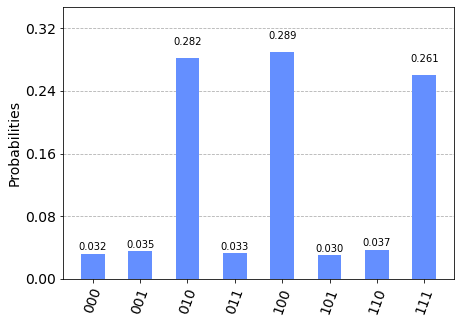

In [131]:
plot_histogram(result['measurement'])